In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dynadojo.systems.lorenz import LorenzSystem
from dynadojo.systems.lds import LDSystem
from dynadojo.wrappers import SystemChecker, AlgorithmChecker
from dynadojo.baselines.transformer import DecoderTransformer
from dynadojo.utils.lds import plot

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

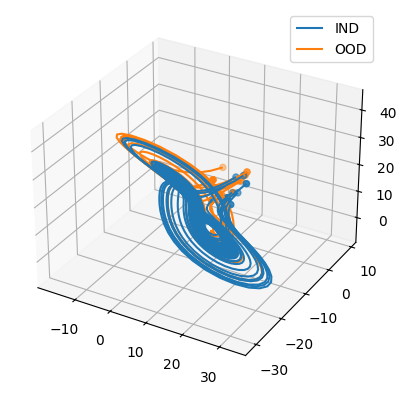

In [3]:
latent_dim = 3
embed_dim = latent_dim
n = 100
test_size = 10
timesteps = 800
system = SystemChecker(LorenzSystem(latent_dim, embed_dim, noise_scale=0, seed=1912,
                                    sigma=10, r=28, a_squared=1/2.0, b=8.0/3.0, 
                                    t_range=(0, 8),
                                    ))
# system = SystemChecker(LDSystem(latent_dim, embed_dim, noise_scale=0, seed=1912))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(30, in_dist=True)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps, noisy=False)
plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

In [4]:
import torch
transformer = AlgorithmChecker(
    DecoderTransformer(embed_dim, timesteps, max_control_cost=0, seed=109, 
                       model_dim=6, num_heads=3, num_layers=6, dropout=0.1, activation="relu",
    )
)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"
transformer._alg.to(device)


DecoderTransformer(
  (embedding): Linear(in_features=3, out_features=6, bias=True)
  (positional_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (linear1): Linear(in_features=6, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=6, bias=True)
        (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropo

In [6]:
transformer.fit(x, 
                epochs=2000,
                batch_size=50,
                learning_rate=1e-1, 
                patience=20,
                min_delta=1e-5,
                validation_split=0.1, 
                verbose=1)


Epoch [1/2000], Loss: 36.5081, Val Loss: 38.4299


KeyboardInterrupt: 

In [ ]:
y_pred = transformer.predict(y[:, 0], timesteps)
y_err = system.calc_error(y, y_pred)
print(f"{y_err=}")
plot([y_pred, y], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)

In [7]:
import torch
model = transformer._alg
model.eval()
initial_conditions = torch.tensor(y[:, 0], dtype=torch.float32).to(model.device) 
next_input = initial_conditions.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)
trajectory = next_input  
# Iteratively predict future values
for _ in range(timesteps - 1):

    with torch.no_grad():
        output = model.forward(next_input)
    print(output.shape)

    next_input = output[:, -1:, :]  # Shape: (batch_size, 1, input_dim)
    trajectory = torch.cat([trajectory, next_input], dim=1)

trajectory.cpu().numpy()

torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size([30, 1, 3])
torch.Size(

array([[[  7.1813784 ,   3.6368117 ,   5.107649  ],
        [  7.6504207 , -12.176885  ,  12.531531  ],
        [  7.6510825 , -12.176469  ,  12.5318985 ],
        ...,
        [  7.6510825 , -12.176469  ,  12.5318985 ],
        [  7.6510825 , -12.176469  ,  12.5318985 ],
        [  7.6510825 , -12.176469  ,  12.5318985 ]],

       [[  2.2005305 ,   2.4766278 ,   9.120342  ],
        [  7.6510797 , -12.176743  ,  12.532071  ],
        [  7.651082  , -12.176469  ,  12.531898  ],
        ...,
        [  7.6510825 , -12.176469  ,  12.5318985 ],
        [  7.6510825 , -12.176469  ,  12.5318985 ],
        [  7.6510825 , -12.176469  ,  12.5318985 ]],

       [[  2.2781832 ,   6.127299  ,   0.18418242],
        [  7.640522  , -11.802878  ,  12.891983  ],
        [  7.651082  , -12.176473  ,  12.5319    ],
        ...,
        [  7.6510825 , -12.176469  ,  12.5318985 ],
        [  7.6510825 , -12.176469  ,  12.5318985 ],
        [  7.6510825 , -12.176469  ,  12.5318985 ]],

       ...,

      

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

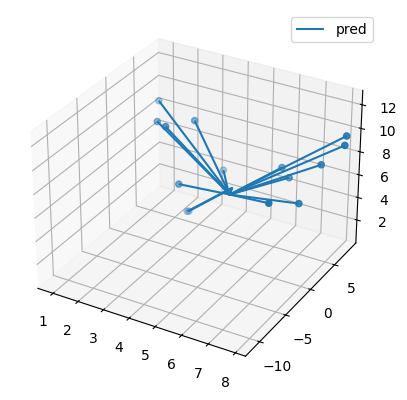

In [9]:
y_pred = trajectory.cpu().numpy()
plot([y_pred, y], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)
# plot([y_pred], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)

In [ ]:
import gc, torch
gc.collect()
torch.mps.empty_cache()

In [ ]:
print(torch.mps.current_allocated_memory())
print(torch.mps.driver_allocated_memory())


In [ ]:
del initial_conditions